# Kinsa Health Weather data scraper

Kinsa is a company that makes Internet-connected thermometers and publishes the subsequent temperature readings in a "US Health Weather Map": https://healthweather.us/?mode=Atypical. Such readings can be classified as an illness when the user has a fever, and from there Kinsa uses an epidemiological model (https://content.kinsahealth.com/covid-detection-technical-approach) to estimate observed %-illness vs what would be expected under their model.

This data has been praised as a pretty decent measure of flu and COVID-19 outbreaks, so below we present a scraper that extracts timeseries data for the "observed" and "atypical" rates of illness published on the US Health Weather Map website.


### How to use:
1. Please see the README.md for all package/software requirements.
2. In code cell 2, select a state with the IPython notebook widget in code cell number 2. Selecting "(all)", the default, will scrape every county's timeseries data across all US states and territories.
3. Continue running the code cells. The scraped data will be saved to a .csv file in the `data` directory.

In [1]:
from datetime import datetime
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from selenium import webdriver 
from selenium.webdriver.common.by import By 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.common.exceptions import TimeoutException

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# -- load in 5-digit FIPS codes for counties.
fips_file = os.path.join('..', 'data', 'ZIP-COUNTY-FIPS_2019-12.csv')
fips_df = pd.read_csv(fips_file
                     , dtype = {'STCOUNTYFP': 'str'})

# -- user to select which state from which they want to scrape Kinsa Health Weather data.
# -- default: scrape all counties across all states (takes a long time!)
state_widget = widgets.Dropdown(options = ['(all)'] + fips_df.STATE.unique().tolist()
                                , value = '(all)'
                                , description = 'Select state:'
                                , disabled = False)
display(state_widget)

Dropdown(description='Select state:', options=('(all)', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', …

In [3]:
# -- kick up selenium chrome browser. This will pop open a chrome browser on your desktop.
option = webdriver.ChromeOptions()
option.add_argument('--incognito')
browser = webdriver.Chrome(executable_path='/usr/local/bin/chromedriver', options=option)

In [4]:
# -- colors of normal, anomalous points
colors = {'observed': '#f98700'
         , 'atypical': '#cb3547'}

# -- URL we'll be scraping
base_url = 'https://healthweather.us/?regionId={fips}&mode=Atypical'

In [5]:
df_list = list()

# -- drill down to state of interest.
state = state_widget.value
if state != '(all)':
    fips_codes = fips_df[fips_df.STATE == state]['STCOUNTYFP'].unique()
else:
    fips_codes = fips_df['STCOUNTYFP'].unique()

n_fips = len(fips_codes)

# -- scrape Health Weather data for each 5-digit state/county FIPS code 
for i in range(n_fips):
    
    # -- identify county, state for scrape.
    fips = fips_codes[i]
    county, state = fips_df[fips_df['STCOUNTYFP'] == fips][['COUNTYNAME', 'STATE']].drop_duplicates().iloc[0, :]
    print(f'Begin scraping Health Weather data for {county}, {state}... ({i + 1}/{n_fips})')
    
    # -- navigate browser to this county
    browser.get(base_url.format(fips=fips))

    # -- wait to scrape site until %-illness data has been rendered.
    try:
        WebDriverWait(browser, 20).until(EC.visibility_of_element_located((By.XPATH, f"//*[name()='svg']//*[name()='circle' and @fill='#f98700']")))
    except TimeoutException:
        print(f'Timed out waiting for {county} Healthweather to load')
        browser.quit()

    # -- figure out the scale of the y-axis in terms of %-illness and pixels
    y_scale = dict()

    y_tix = browser.find_elements_by_xpath("//*[name()='g']//*[name()='text' and @class='recharts-text recharts-cartesian-axis-tick-value']")
    for y_tick in y_tix:
        y_scale[int(y_tick.text)] = y_tick.get_property('y')['baseVal'][0]['value']

    # -- SVG y-scale starts from top-left corner, not bottom left (as in Cartesian coordinates).
    # -- Therefore 0%-illness = max(y).
    y_max = y_scale.get(0)

    # -- scale pixels to %-illness.
    max_illness = max(y_scale.keys())
    pixel_to_illness = max_illness / (y_scale[0] - y_scale[max_illness])

    x_start = browser.find_elements_by_xpath("//*[name()='g']//*[name()='text' and @class='recharts-text' and @text-anchor='start']")
    start_date = x_start[0].text

    # -- store (x, y) representing dates, illness rates in the atypical vs. expected graph.
    data_dict = {'observed': {'x': list()
                             , 'y': list()}
                , 'atypical': {'x': list()
                              , 'y': list()}}

    # -- scrape observed, atypical %-illness points.
    for color in colors:
        circles = browser.find_elements_by_xpath(f"//*[name()='svg']//*[name()='circle' and @fill='{colors.get(color)}']")
        for circle in circles:
            x, y = circle.value_of_css_property('cx'), circle.value_of_css_property('cy')
            x = float(x.replace('px', ''))
            y = float(y.replace('px', ''))
            data_dict[color]['x'].append(x)
            data_dict[color]['y'].append(pixel_to_illness * (y_max - y))

    # -- store data into DataFrames... start with observed %-illness
    df_observed = pd.DataFrame({'x': data_dict['observed']['x']
                               , 'y': data_dict['observed']['y']
                               , 'condition': 'observed'})
    df_observed.drop_duplicates('x'
                                , inplace=True)
    df_observed['date'] = [datetime.strptime(start_date + ' 2020', '%b %d %Y') + timedelta(days = x) 
                           for x in range(df_observed.shape[0])]
    
    # -- check that we actually scraped data...
    if df_observed.empty:
        raise ValueError(f'observed %-illness data for {county}, {state} is empty!')
   
    # -- store %-atypical illness into DataFrame
    df_atypical = pd.DataFrame({'x': data_dict['atypical']['x']
                               , 'y': data_dict['atypical']['y']
                               , 'condition': 'atypical'})
    df_atypical.drop_duplicates('x'
                               , inplace=True)
    
    # -- since atypical illness data is a subset of observed illness data,
    # -- we determine dates of atypical illness by joining the two datasets on the x-axis pixel location.
    df_atypical = pd.merge(df_observed[['x', 'date']]
                           , right = df_atypical
                           , on = 'x')
        
    # -- stack observed, atypical datasets.
    df = pd.concat([df_observed, df_atypical])
    
    # -- append geoloco metadata.
    df['county'] = county
    df['state'] = state
    df['fips'] = fips
    print(f'Successfully scraped {df.shape[0]} Health Weather data points for {county}, {state}.')
    
    df_list.append(df)
    
# -- close browser.
browser.close()

# -- concatenate county-level DataFrames.
df = pd.concat(df_list)
df['illness'] = df['y']
df.drop(['x', 'y']
        , axis=1
        , inplace=True)

# -- save scraped data to disk.
df.to_csv(os.path.join('..', 'data', f'{state}_health_weather.csv')
          , index = False)

Begin scraping Health Weather data for Adams County, IL... (1/102)
Successfully scraped 64 Health Weather data points for Adams County, IL.
Begin scraping Health Weather data for Alexander County, IL... (2/102)
Successfully scraped 64 Health Weather data points for Alexander County, IL.
Begin scraping Health Weather data for Bond County, IL... (3/102)
Successfully scraped 64 Health Weather data points for Bond County, IL.
Begin scraping Health Weather data for Boone County, IL... (4/102)
Successfully scraped 64 Health Weather data points for Boone County, IL.
Begin scraping Health Weather data for Brown County, IL... (5/102)
Successfully scraped 64 Health Weather data points for Brown County, IL.
Begin scraping Health Weather data for Bureau County, IL... (6/102)
Successfully scraped 64 Health Weather data points for Bureau County, IL.
Begin scraping Health Weather data for Calhoun County, IL... (7/102)
Successfully scraped 64 Health Weather data points for Calhoun County, IL.
Begin sc

Successfully scraped 66 Health Weather data points for Macon County, IL.
Begin scraping Health Weather data for Macoupin County, IL... (59/102)
Successfully scraped 65 Health Weather data points for Macoupin County, IL.
Begin scraping Health Weather data for Madison County, IL... (60/102)
Successfully scraped 64 Health Weather data points for Madison County, IL.
Begin scraping Health Weather data for Marion County, IL... (61/102)
Successfully scraped 64 Health Weather data points for Marion County, IL.
Begin scraping Health Weather data for Marshall County, IL... (62/102)
Successfully scraped 64 Health Weather data points for Marshall County, IL.
Begin scraping Health Weather data for Mason County, IL... (63/102)
Successfully scraped 64 Health Weather data points for Mason County, IL.
Begin scraping Health Weather data for Massac County, IL... (64/102)
Successfully scraped 64 Health Weather data points for Massac County, IL.
Begin scraping Health Weather data for Menard County, IL... (

In [43]:
def plot_county_health_weather(X, county, state, figsize=[12, 9]):
    """
    Plot a county's Kinsa Health Weather timeseries data.
    
    Args
    ---------
    X: {pandas DataFrame} Kinsa Health Weather dataframe. Must have 'county',
        'condition', 'date', and 'illness' columns.
    county: {str} name of a county in the 'county' field in X
    state: {str} name of a state in the 'state' field in X
    figsize:
    """
    if list(set(['county', 'condition', 'date', 'illness']) - set(X.columns)):
        raise ValueError('X is missing either a "county", "condition", "date", or "illness" column.')
        
    fig, ax = plt.subplots(figsize = figsize)
    for (condition, lty) in (('observed', 'b-'), ('atypical', 'ro')):
        plot_df = df[((df.county == county) & (df.state == state) & (df.condition == condition))]

        if not plot_df.empty:
            ax.plot(plot_df.date
                    , plot_df.illness
                    , lty
                    , label = condition)
            
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    ax.set_title(f'{county}, {state} %-illness')
    ax.set_ylabel('%-illness')
    ax.legend(loc = 'upper right')
    
    return ax

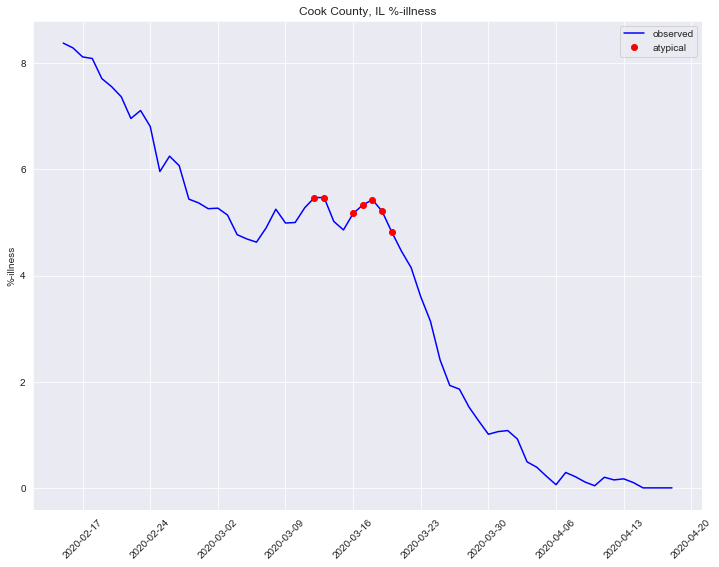

In [44]:
p_cc = plot_county_health_weather(df
                                  , county = 'Cook County'
                                  , state = 'IL')

p_cc.figure.savefig('cook_county_il.png')

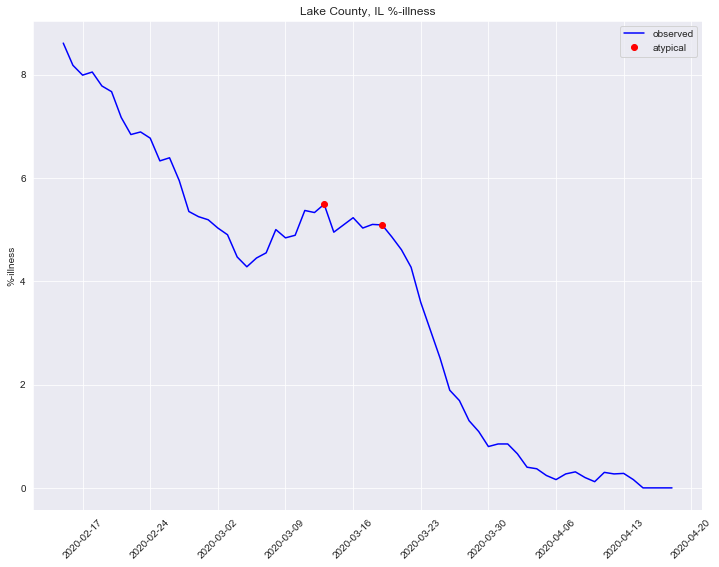

In [45]:
p_lc = plot_county_health_weather(df
                                  , county = 'Lake County'
                                  , state = 'IL')

p_lc.figure.savefig('lake_county_il.png')

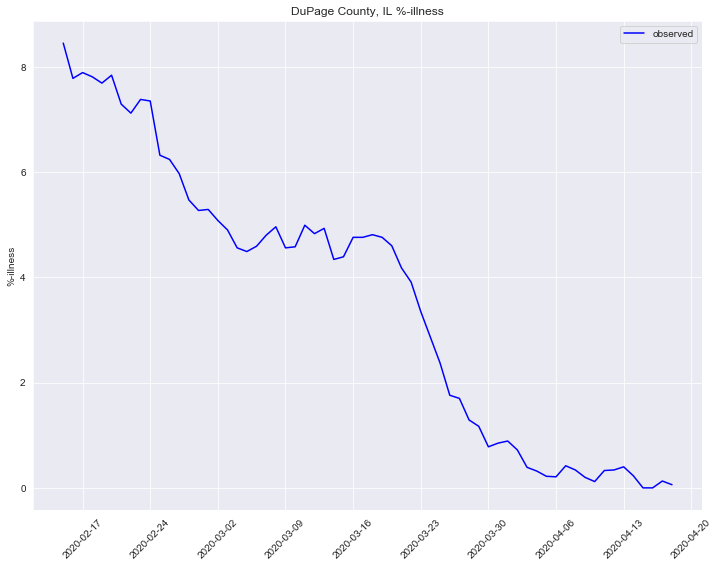

In [46]:
plot_county_health_weather(df
                           , county = 'DuPage County'
                           , state='IL')